In [1]:
import pandas as pd
from datetime import date
import os
from sportsipy.ncaab.boxscore import Boxscores
from scraper import map_name_to_kenpom

projection_data_dir = "./data/projections_data"
old_projection_data = "./data/projection_data_old_names"

In [2]:
SPORTSIPY_KENPOM = {'Alabama Birmingham': 'UAB',
                    'Albany NY': 'Albany',
                    'Bowling Green St.': 'Bowling Green',
                    'Brigham Young': 'BYU',
                    'Cal State Bakersfield': 'Cal St. Bakersfield',
                    'Cal State Fullerton': 'Cal St. Fullerton',
                    'Cal State Northridge': 'Cal St. Northridge',
                    'California Baptist': 'Cal Baptist',
                    'University of California': 'UCLA',
                    'Central Connecticut St.': 'Central Connecticut',
                    'Central Florida': 'UCF',
                    'Citadel': 'The Citadel',
                    'College of Charleston': 'Charleston',
                    'Detroit Mercy': 'Detroit',
                    'Florida International': 'FIU', 
                    'Grambling': 'Grambling St.',
                    'Cal State Long Beach': 'Long Beach St.',
                    'Long Island University': 'LIU',
                    'Louisiana St.': 'LSU',
                    'Loyola IL': 'Loyola Chicago',
                    'Maryland Baltimore County': 'UMBC',
                    'Massachusetts Lowell': 'UMass Lowell',
                    'Missouri Kansas City': 'UMKC',
                    'Omaha': 'Nebraska Omaha',
                    'Nevada Las Vegas': 'UNLV',
                    'North Carolina Asheville': 'UNC Asheville',
                    'North Carolina Greensboro': 'UNC Greensboro',
                    'North Carolina St.': 'N.C. State',
                    'North Carolina Wilmington': 'UNC Wilmington',
                    'Pennsylvania': 'Penn',
                    'Prairie View': 'Prairie View A&M',
                    'Saint Francis PA': 'St. Francis PA',
                    "Saint Mary's CA": "Saint Mary's",
                    'South Carolina Upstate': 'USC Upstate',
                    'Southern California': 'USC',
                    'Southern Methodist': 'SMU',
                    'Southern Mississippi': 'Southern Miss',
                    "St. John's NY": "St. John's",
                    'Texas A&M Corpus Christi': 'Texas A&M Corpus Chris',
                    'Texas Arlington': 'UT Arlington',
                    'Texas Christian': 'TCU',
                    'Texas El Paso': 'UTEP',
                    'Texas Rio Grande Valley': 'UT Rio Grande Valley',
                    'Texas San Antonio': 'UTSA',
                    'Virginia Commonwealth': 'VCU'}

#mapping dictionary and function
def map_spy_to_kenpom(name_spy):
    name_kp = name_spy
    name_kp = name_kp.replace('(', '')
    name_kp = name_kp.replace(')', '')
    name_kp = name_kp.replace('-', ' ')
    
    if(name_kp.endswith("State")):
        name_kp = name_kp[:-5] + "St."
    
    try:
        name_kp = SPORTSIPY_KENPOM[name_kp]
    except KeyError:
        pass
    
    #print(name_spy, name_kp, sep=" > ")
    return name_kp

In [3]:
projection_files = os.listdir(projection_data_dir)
file = projection_files[0]
file_df = pd.read_excel(projection_data_dir + "/" + file, engine="openpyxl")


In [4]:
projections_df = pd.DataFrame()
projection_count = 0
boxscore_count = 0

for file in projection_files:
    #process the projection file into a dataframe
    file_df = pd.read_excel(projection_data_dir + "/" + file, engine="openpyxl")
    file_df.drop(columns=["Unnamed: 0"], inplace=True)
    file_date = file.split('_')[0]
    file_date_obj = date(int(file_date[:4]), int(file_date[4:6]), int(file_date[-2:]))
    file_df["date"] = file_date_obj
    
    #gather the boxscore data for the day and process into a dataframe
    try:
        games = Boxscores(file_date_obj, file_date_obj).games[file_date_obj.strftime("%m-%d-%Y")]
    except KeyError:
        print("Key Error getting games for ", file_date_obj.strftime("%m-%d-%Y"))
        continue #process the next file
        
    boxscore_df = pd.DataFrame()
    for game in games:
        game_df = pd.DataFrame(game, index=[0])
        boxscore_df = boxscore_df.append(game_df, ignore_index=True)

    boxscore_drop_cols = ["away_abbr", "home_abbr", "away_rank", "home_rank", "winning_abbr", "losing_abbr"]
    boxscore_df.drop(columns=boxscore_drop_cols, inplace=True)
    boxscore_df.home_name = boxscore_df.apply(lambda row: map_spy_to_kenpom(row.home_name), axis=1)
    boxscore_df.away_name = boxscore_df.apply(lambda row: map_spy_to_kenpom(row.away_name), axis=1)
    boxscore_df.rename(columns={"home_name":"home_team", "away_name":"away_team"}, inplace=True)
    
    #get only the D1 games
    boxscore_df = boxscore_df[~boxscore_df["non_di"]]
    
    merged_df = pd.merge(file_df, boxscore_df, how='left', on=['home_team', 'away_team'])
    
    
    projections_df = projections_df.append(merged_df)
    
    
    projection_count += file_df.shape[0]
    boxscore_count += boxscore_df.shape[0]
    

Key Error getting games for  02-18-2021
Key Error getting games for  02-20-2021
Key Error getting games for  02-25-2021
Key Error getting games for  02-19-2021
Key Error getting games for  02-22-2021
Key Error getting games for  02-24-2021
Key Error getting games for  02-21-2021


In [5]:
projections_df.drop(columns=['Unnamed: 0.1'], inplace=True, axis=1)

In [6]:
projections_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 0 to 28
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   home_team             155 non-null    object 
 1   away_team             155 non-null    object 
 2   home_projected_score  155 non-null    float64
 3   away_projected_score  155 non-null    float64
 4   projected_total       155 non-null    float64
 5   total                 155 non-null    float64
 6   edge                  155 non-null    float64
 7   pick                  133 non-null    object 
 8   date                  155 non-null    object 
 9   boxscore              87 non-null     object 
 10  away_score            87 non-null     float64
 11  home_score            87 non-null     float64
 12  non_di                87 non-null     object 
 13  top_25                87 non-null     object 
 14  winning_name          87 non-null     object 
 15  losing_name           87

In [7]:
print(projection_count, boxscore_count)

155 120


In [8]:
# look at the names that didnt mathc
# Aubrun/Indiana/Butler should all match
# query sports refereence api for 2020/12/20 boxscore and check team names

nans = projections_df[projections_df['boxscore'].isnull()]
nan_date = nans.date.loc[1]

In [9]:
games = Boxscores(nan_date, nan_date).games[nan_date.strftime("%m-%d-%Y")]

In [10]:
boxscore_df = pd.DataFrame()
for game in games:
    game_df = pd.DataFrame(game, index=[0])
    boxscore_df = boxscore_df.append(game_df, ignore_index=True)

In [11]:
boxscore_df

,boxscore,away_name,away_abbr,away_score,away_rank,home_name,home_abbr,home_score,home_rank,non_di,top_25,winning_name,winning_abbr,losing_name,losing_abbr
0,2020-12-20-19-northwestern,Michigan State,michigan-state,65,4,Northwestern,northwestern,79,None,False,True,Northwestern,northwestern,Michigan State,michigan-state
1,2020-12-20-16-houston,Alcorn State,alcorn-state,55,None,Houston,houston,88,6,False,True,Houston,houston,Alcorn State,alcorn-state
2,2020-12-20-12-connecticut,Creighton,creighton,76,9,UConn,connecticut,74,None,False,True,Creighton,creighton,UConn,connecticut
3,2020-12-20-14-texas,Oklahoma State,oklahoma-state,74,None,Texas,texas,77,11,False,True,Texas,texas,Oklahoma State,oklahoma-state
4,2020-12-20-13-rutgers,Illinois,illinois,88,13,Rutgers,rutgers,91,19,False,True,Rutgers,rutgers,Illinois,illinois
5,2020-12-20-18-nevada,Air Force,air-force,68,None,Nevada,nevada,66,None,False,False,Air Force,air-force,Nevada,nevada
6,2020-12-20-17-james-madison,Alice Lloyd,Alice Lloyd,55,None,James Madison,james-madison,98,None,True,False,James Madison,james-madison,Alice Lloyd,Alice Lloyd
7,2020-12-20-18-texas-el-paso,Benedictine,Benedictine,59,None,UTEP,texas-el-paso,79,None,True,False,UTEP,texas-el-paso,Benedictine,Benedictine
8,2020-12-20-19-georgia-southern,Carver College,Carver College,43,None,Georgia Southern,georgia-southern,119,None,True,False,Georgia Southern,georgia-southern,Carver College,Carver College
9,2020-12-20-16-arkansas-state,Champion Christian,Champion Christian,50,None,Arkansas State,arkansas-state,90,None,True,False,Arkansas State,arkansas-state,Champion Christian,Champion Christian


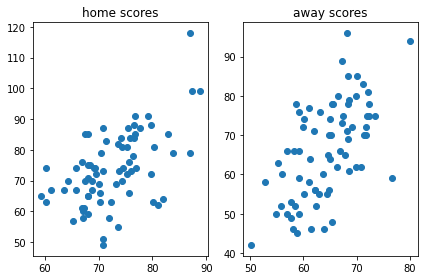

In [25]:
import matplotlib.pyplot as plt
data_df = projections_df.dropna()
home_x = data_df.home_projected_score
home_y = data_df.home_score

away_x = data_df.away_projected_score
away_y = data_df.away_score

plt.figure()
plt.subplot(121)
plt.scatter(home_x, home_y)
plt.title("home scores")

plt.subplot(122)
plt.scatter(away_x, away_y)
plt.title("away scores")
plt.tight_layout()